# Course Four: Build a Regressor

Expected time to complete: 1 hour

## Goal of this Course
During this course we will build a regressor to forecast the minutes watched within the last two-week group.

This course is split into the following parts:
- <a href='#context'>Context</a> 
- <a href='#model_evaluation'>Model Evaluation</a> 
- <a href='#baseline_forecast'>Baseline Forecast</a>
    - <a href='#load_data'>Load the Data</a>
    - <a href='#define_baseline'>Define a Baseline</a>


- <a href='#linear_reg'>Multivariate Linear Regression</a>
    - <a href='#model_training'>Model Training</a>
    - <a href='#linear_reg_und'>Understanding our Multivariate Linear Regression</a>


- <a href='#ridge_reg'>Ridge Regression</a>
    - <a href='#model_training2'>Model Training and Hyperparameters Tuning</a>
    - <a href='#best_ridge_reg'>Understanding our Best Ridge Regression</a>


- <a href='#lasso_reg'>Lasso Regression</a>
    - <a href='#model_training3'>Model Training and Hyperparameters Tuning</a>
    - <a href='#best_lasso_reg'>Understanding our Best Lasso Regression</a>


- <a href='#model_perf_comp'>Model Performance Comparison</a> 
- <a href='#combine_mod'>Combine the Regression and Classification Models</a>

<a id='context'></a>
# Context
In the previous tutorial we explained how the training process works and how to evaluate our models in the classification framework. We built four models that predicted whether a user would consume content within a two-week period based upon their past behaviour over the previous 14 weeks. 

Forecasting whether or not a given user will return to BBC services is very useful for the BBC. It provides valuable insight and feedback on the way we are surfacing content to our users and, in particular,  identifies the users where we need to do better.

Data on the engagement of returning audience members is also useful. From the pool of audience members that did return, there will be valuable variation in the amount of content they consume. The aim of this current tutorial is to forecast the _quantity_ of content consumed by an audience member within a two-week period, based upon their consumption behaviour in the previous weeks. 

In order to forecast the minutes watched within the final two-week group we will first define our evaluation metric. As we did for the classifiers in the previous tutorial, we will then train different models, compare their performances to a baseline and benchmark their results. 


<a id='model_evaluation'></a>
# Model Evaluation

Evaluating the performance of a regressor is slightly less straightforward than a classifier although it is based upon the same principle: we define an error, then compare the error of our model to the expected error of a baseline model.   

For regressors, the error is computed as the average residual between the actual observations and the model predictions. 

__Root mean squared error__ (RMSE) and __mean absolute error__ (MAE) are two commonly used examples of these. Once we have a representation of the error produced by the model we can compare that error with the error of the most simple model of the data (usually the mean). The statistic that reflects this difference is known as the coefficient of determination or __R-squared__. R-squared measures the goodness-of-fit of a model and can be thought of as the proportion of variance in the model output y that is captured by our model. In order to control for the complexity of the regressions we usually consider the __Adjusted R-squared__. We won't compute any of these statistics here but it's a good exercice for the reader.

<a id='baseline_forecast'></a>
# Baseline Forecast

<a id='load_data'></a>
## Load the Data
First, let's get our data back and check to make sure it looks familiar.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
# We put both target arrays (regression and classification) in the same txt file
# As both target arrays have the same size we just need to split it it two
# and get the correct part for the prediction task
target = np.split(np.loadtxt('target.txt'), 2)[0].flatten()
features = pd.read_csv('features.csv')

# User id as index
features = features.set_index('user_id')

In [3]:
# Make sure we have the right input database
features.head()

,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,num_genre,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
user_id,,,,,,,,,,,,,,,,,,,,,
0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,1,...,1,0,0,0,0,0,0,1,0,0
000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,5,...,0,0,1,0,0,0,0,0,1,0
001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.489419,3,2,...,0,1,0,0,0,0,0,0,1,0
001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,2,...,0,0,0,0,0,1,0,0,1,0
002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.228233,17,5,...,0,1,0,0,0,0,0,1,0,0


In [4]:
# Make sure we have the right output
target[:10]

array([  1.44833333e-01,   3.18047633e+02,   1.98035000e+00,
         1.00590667e+01,   0.00000000e+00,   4.79261667e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

<a id='define_baseline'></a>
## Define a Baseline

As mentionned in the previous course we should have a baseline to compare the performance of our models with. Here, as we are forecasting a quantitative variable, the most simple model is the one that predicts a constant value, such as  zero, the mean or the median of our data. 

Note that by default `scikit` _maximises_ an inverse error function as opposed to minimising an error function.  We therefore negate the error we compute for our baseline model to make it comparable with the performance metric we will pull out of our statistical models.

In [5]:
# Create a baseline to compare our results to (mean and median minutes watched and 0)
mean=np.mean(target)
median=np.median(target)

mean_forecast=[mean]*len(target)
median_forecast=[median]*len(target)
zero_forecast=[0]*len(target)

In [6]:
print("Mean: "+str(mean))
print("Median: "+str(median))

Mean: 75.9168097123
Median: 0.0


The median is null, meaning that more than half of our users did not consume content on iPlayer within the last two weeks.

There is no need to consider the constant model equal to 0 as a baseline here (same as the median one).

In [7]:
# Compute the errors for these different baselines
from sklearn import metrics
print("Score if we forecast the mean:",
      -metrics.mean_absolute_error(target,mean_forecast))
print("Score if we forecast the median:",
      -metrics.mean_absolute_error(target,median_forecast))

Score if we forecast the mean: -115.319756974
Score if we forecast the median: -75.9168097123




We will now train a series of different kinds of regression models.

These models should provide great business insight as we can __quantify the impact__ of each input variable upon our "engagement" output variable.

<a id='linear_reg'></a>
# Multivariate Linear Regression

The easiest way to relate our output variable to our input ones is to use a __linear combination__.

A linear regression model decomposes the observed output in an additive way such that the coefficients we estimate in the training process can be interpreted as the impact of a given input all other things being equal (AOTBE). For more details see: https://en.wikipedia.org/wiki/Linear_regression

And for the `scikit learn` documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [8]:
# Let's build a simple regression
from sklearn import linear_model

# We will use cross validation, so import helper functions for this
from sklearn.model_selection import cross_val_score, cross_val_predict

# Plots
from matplotlib import pyplot as plt 

<a id='model_training'></a>
## Model Training

For this model there is no hyperparameter to tune. Indeed, the model only has to evaluate the _contribution_ of each input variable to the linear combination.  

Maintaining a train/test split is just as important when using regression models as it is with classification models, so we will use the `cross_val_score` function again here. This gives us the negative mean absolute error for each of the _k_ validation folds. In addition we use the `cross_val_predict` function to get the raw linear predictions. This function returns the predicted target value of each datapoint in our dataset while ensuring the model used to predict each datapoint has not been trained upon that datapoint.

In [9]:
# We setup a simple linear regression, again using cross validation
reg=linear_model.LinearRegression()

MR_oos=cross_val_score(reg, features, target, scoring='neg_mean_absolute_error')
MR_r2 = cross_val_score(reg, features, target, scoring='r2')
predicted=cross_val_predict(reg, features,target)

In [10]:
# Compute the mean error obtained in the CV
print("Mean inverse out-of-sample error:", np.mean(MR_oos))

Mean inverse out-of-sample error: -58.0733721136


So we now have an indication of the performance of our first regressor model. Fortunately, the score is higher than either of our baseline scores (-115 and -76) meaning that our model is capturing some meaningful information about our output "engagement" variable.

We can also plot our predicted values against the output we actually observe. The more the dots are close to the first bisector, the better are our forecasts. 

We can also evaluate the strength of the linear relationship between the predicted and actual output values by calculating the correlation of the two.

Pearson correlation coefficient: 0.798919075010642
P-value 0.0


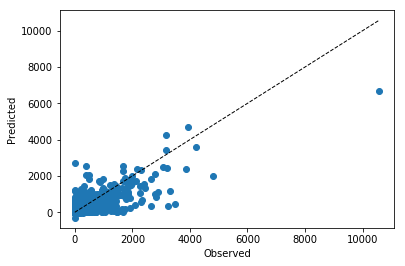

In [11]:
# First let's see how correlated the predicted and actual output variables are.
from scipy.stats.stats import pearsonr
MR_r, p  = pearsonr(target,predicted)
print('Pearson correlation coefficient: {}'.format(MR_r) )
print("P-value {}".format(p))

# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()

So a correlation coefficient 0.8 represents a strong linear relationship between the two variables. The P-value of 0.0 represents the significance of the test. The __p-value__ is a number between 0 and 1 and can be interpreted as the probability that the reported effect is not real and actually happened by chance. In most behavioural studies p-values of below 0.05 are considered significant. Be aware that this significance level is, essentially, arbitrary and varies from field to field. 

From inspecting the scatter plot we see the illustration of the reported linear relationship. One thing to note from the plot is that an outlier exists in the top right corner. It is worth mentioning that a single outlier like that can have a significant impact upon correlation coefficient. So, for a more accurate reflection of the linear relationship, that outlier should be removed _before_ performing the correlation test, or even before the modeling part.


<a id='linear_reg_und'></a>
## Understanding our Multivariate Linear Regression

Now that we have evaluated the performance of our model using the out-of-sample error, next, let's see if we can understand how the model is working. To do this, we will train one model using our entire dataset and the estimated coefficients will represent the importance the model is affording to each feature.

In [12]:
# Let's train on all data 
lin_reg=linear_model.LinearRegression()
MR=lin_reg.fit(features,target)

In [13]:
# In-sample error
from sklearn.metrics import mean_absolute_error
MR_is = -metrics.mean_absolute_error(target,MR.predict(features))
print("Inverse in-sample error: {}".format(MR_is))

Inverse in-sample error: -56.600083327149065


So our inverse in-sample error is -56.6 while our inverse out-of-sample (average) error is -58. This looks sensible as, remember that in-sample accuracy will always be higher than out-of-sample one. The fact that these two values are not far apart is an indication that the model is well-fitted.

Now let's have a look at the estimeted coefficients to understand the drivers of the _volume_ of minutes watched.

In [14]:
# First, let's have a look at the highest magnitude positive coefficients.
coefMR=pd.DataFrame(
    {'feature': list(features.columns),
     'coefficient': list(MR.coef_)
    })
coefMR.sort_values(by='coefficient', ascending=False).reset_index(drop=True).head()

,coefficient,feature
0,6.541515,most_weekday_weekday_2
1,4.831388,most_genre_Sport
2,3.625429,most_genre_Drama
3,2.676683,most_timeday_Afternoon
4,2.654163,most_genre_News
5,2.148542,most_genre_Entertainment
6,1.889999,most_weekday_weekday_6
7,1.302314,num_genre
8,1.081513,most_genre_Religion & Ethics
9,0.849109,average_completion


In [15]:
# Now lets have a look at the highest magnitude negative coefficients.
coefMR.sort_values(by='coefficient', ascending=False).reset_index(drop=True).tail()

,coefficient,feature
29,-6.872885,most_genre_Music
30,-7.023103,most_timeday_Evening
31,-8.022035,most_timeday_Night
32,-9.211985,most_weekday_weekday_0
33,-16.821276,most_genre_Children's


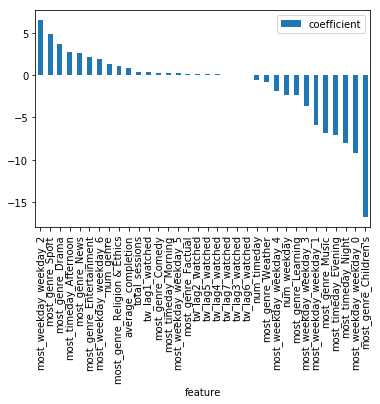

In [16]:
# Now let's plot them all
coefMR = coefMR.set_index(['feature'])
coefMR.sort_values(by='coefficient', ascending=False).plot(kind='bar')
plt.show()

The results are quite interesting here. It seems that some particular habits __drive__ the amount of content consumed.

The table of positive coefficients indicate the features that are positively correlated with minutes watched. So, users that consume most iPlayer content on Wednesdays, or in the afternoon, or whose favourite genre is Sport are more likely to consume more content overall. Conversely, users whose favourite genre is Children's or who consume most of their content on a Monday do not consume - in terms of total of minutes - as much. It's difficult to speak of drivers for _engagement_ here because the minutes watched is highly correlated to the type of content. For example, Children's  content are, on average, shorter than Sport or Drama so it makes sense that people that watch long shows watch more minutes than people that watch short shows. It doesn't necessarily mean than the user's who consume only Children's content are less engaged. 

More specifically, the estimated coefficients can be interpreted as follows. Let's take the `num_genre` variable, whose estimated coefficient and therefore model contribution is 1.3. This means that, if we hold all other features constant, for each user that views one additional genre in the 14-week training period (`num_genre+=1`), the model output prediction will get additional 1.3 minutes of consumed content. While this feature alone would not make a very accurate model for our purpose, it makes sense that the more genre's an audience member consumes, the more engaged they are.

N.B. For the estimated coefficients we should in theory have a look at the __p-values__ for each - statistic values that indicate whether our estimated coefficient is significantly different from zero. We won't go more into details here but the reader is encouraged to explore this as an exercise.

<a id='ridge_reg'></a>
# Ridge Regression
In many situations, trained multivariate linear regression models have very large coefficients. Unfortunately, experience tells that large coefficients tend to lead to more complex models that overfit the data. __Regularization__ models various techniques to avoid this problem.

Ridge regression, also referred to as __L2 regularization__ is a variant of multivariate regression that adds a term, _alpha_, that penalises the sum-squared of the coefficients. 

In practical terms, an alpha of zero will train a model that is identical to multivariate linear regression and as we increase _alpha_ the magnitude of the coefficients will be increasingly constrained.

`Scikit documentation`: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

<a id='model_training2'></a>
## Model Training and Hyperparameters Tuning
The _alpha_ term just described is a hyperparameter that we need to tune.  Let's use the same approach we used for the classification models and do a grid search.

In [17]:
# Setup the model and develop a simple grid search against some key parameters
RR_param_alpha=[0.001,0.01,0.1,1.0,10,100]

In [18]:
# Let's keep track of our best parameters
RR_best_score=-200
RR_best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in RR_param_alpha:
    reg_r = linear_model.Ridge(alpha = i)
    scores=cross_val_score(reg_r,
                           features,
                           target,
                           scoring='neg_mean_absolute_error')
    
    if np.mean(scores)>RR_best_score:
        RR_best_score=np.mean(scores)
        RR_best_param=i

# print the overall best results
print('Best Settings: alpha:',RR_best_param)
print('Inverse out-of-sample error:',RR_best_score)

Best Settings: alpha: 100
Inverse out-of-sample error: -57.6212395997


So a ridge regression model does _slightly_ better than our previous multivariate linear regression model.

Now let's look at the relationship between the predicted and actual values.

Pearson correlation coefficient: 0.7991074107638553
P-value 0.0


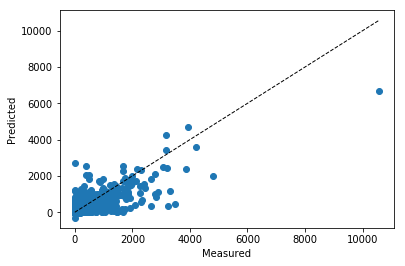

In [19]:
# First let's see how correlated the predicted and actual output variables are.
reg_r=linear_model.Ridge(alpha=RR_best_param)
predicted=cross_val_predict(reg_r,features,target)
RR_r, p  = pearsonr(target,predicted)
print('Pearson correlation coefficient: {}'.format(RR_r) )
print("P-value {}".format(p))

# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

The data (both the plot and the correlation coefficient) look very similar to the data produced by the previous linear regression model so there are no more insights to be made here.

<a id='best_ridge_reg'></a>
## Understanding our Best Ridge Regression

As before, to explore our best ridge regression model we will train a new model using the entire dataset.

In [20]:
# Let's keep our best model (hyperparameters tuned)
ridge=linear_model.Ridge(alpha=RR_best_param)
RR=ridge.fit(features,target)

In [21]:
# In-sample error
RR_is=-metrics.mean_absolute_error(target,RR.predict(features))
print("Inverse in-sample error: {}".format(RR_is))

Inverse in-sample error: -56.349642485604285


The in-sample performance metric looks sensible.

Now let's look at the coefficients, where we should see a difference from our linear regression model.

In [22]:
# Let's have a look at the estimated coefficients
coefRR=pd.DataFrame(
    {'feature': list(features.columns),
     'coefficient': list(RR.coef_)
    })
# Make the index the feature label.
coefRR = coefRR.set_index(['feature'])

In [23]:
# First, let's have a look at the highest magnitude positive coefficients.
coefRR.sort_values(by='coefficient', ascending=False).head()

,coefficient
feature,
most_weekday_weekday_2,7.421033
most_timeday_Afternoon,4.944781
most_genre_Sport,4.792979
most_genre_Drama,3.844478
most_weekday_weekday_6,3.292293


In [24]:
# Then, let's have a look at the highest magnitude negative coefficients.
coefRR.sort_values(by='coefficient', ascending=False).tail()

,coefficient
feature,
most_weekday_weekday_1,-4.066270
most_timeday_Evening,-4.210816
most_timeday_Night,-4.714957
most_weekday_weekday_0,-7.108479
most_genre_Children's,-12.450369


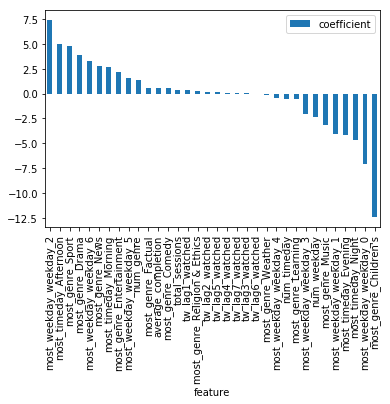

In [25]:
# Now let's plot them all
coefRR.sort_values(by='coefficient', ascending=False).plot(kind='bar')
plt.show()

As expected, the shape of the distribution of coefficients has not changed noticebly, however, the absolute values of those coefficients is much lower than it was for the linear regression model.

<a id='lasso_reg'></a>
# Lasso Regression

Lasso regression is another variant of multivariate regression and is often referred to as __L1 regularisation__. Instead of penalising the sum-squared of the coefficients (as in ridge regression), lasso regression penalises the absolute sum square of the coefficients. 

In practical terms, this has the effect of limiting the number of non-zero coefficients in the model. This makes lasso regression a convenient method of feature selection.

`Scikit documentation`: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

<a id='model_training3'></a>
## Model Training and Hyperparameters Tuning

Again, we need to tune the penalty parameter _alpha_. In lasso regression, the _alpha_ parameter varies the number of non-zero coefficients. An _alpha_ of zero will produce a model that is equal to linear regression and as _alpha_ increases the number of non-zero coefficients is increasingly constrained.

In [26]:
# Setup the model and develop a simple grid search against some key parameters
LR_param_alpha=[0.001,0.01,0.1,1.0,10,100]

In [27]:
# Let's keep track of our best parameters
LR_best_score=-200
LR_best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in LR_param_alpha:
    reg_l = linear_model.LassoLars(alpha = i)
    scores=cross_val_score(reg_l,
                           features,
                           target,
                           scoring='neg_mean_absolute_error')
    if np.mean(scores)>LR_best_score:
        LR_best_score=np.mean(scores)
        LR_best_param=i

# print the overall best results
print('Best Settings: alpha:',LR_best_param)
print('Score:',LR_best_score)

Best Settings: alpha: 0.1
Score: -56.2569583055


So our best alpha parameter is 0.1 and our best performance metric is -56, which is marginally better than both of our previous models (achieving -58 and 57.6).



Pearson correlation coefficient: 0.7999888895572336
P-value 0.0


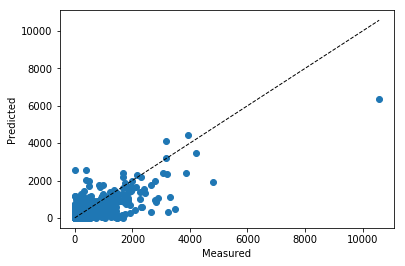

In [28]:
# First let's see how correlated the predicted and actual output variables are.
reg_l=linear_model.LassoLars(alpha=LR_best_param)
predicted=cross_val_predict(reg_l,features,target)
LR_r, p  = pearsonr(target,predicted)
print('Pearson correlation coefficient: {}'.format(LR_r) )
print("P-value {}".format(p))

# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target,predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Again, the scatter plot and correlation statistics look very similar to those generated using data from our previous regression models. So there are no further insights to be made here.

<a id='best_lasso_reg'></a>
## Understanding our Best Lasso Regression

In [29]:
# Let's keep our best model (hyperparameters tuned)
lasso=linear_model.LassoLars(alpha=LR_best_param)
LR=lasso.fit(features,target)

In [30]:
# In-sample error
LR_is=-metrics.mean_absolute_error(target,LR.predict(features))
print(LR_is)

-55.8993812974


Our in-sample error looks sensible. Now let's look at the estimated coefficients.

We should expect to see quite significant differences in the distribution of coefficients in our lasso model due to how it penalises the number of non-zero weights.

In [31]:
# Let's have a look at the estimated coefficients
coefLR=pd.DataFrame(
    {'feature': list(features.columns),
     'coefficient': list(LR.coef_)
    })
# Make the index the feature label.
coefLR=coefLR.set_index(['feature'])

In [32]:
# First, let's have a look at the highest magnitude positive coefficients.
coefLR.sort_values(by='coefficient', ascending=False).head()

,coefficient
feature,
tw_lag1_watched,0.331655
total_sessions,0.300884
tw_lag2_watched,0.167153
tw_lag5_watched,0.114044
tw_lag4_watched,0.066689


In [33]:
# Then, let's have a look at the highest magnitude negative coefficients.
coefLR.sort_values(by='coefficient', ascending=False).tail()

,coefficient
feature,
num_timeday,0.0
num_weekday,0.0
num_genre,0.0
average_completion,0.0
most_timeday_Night,0.0


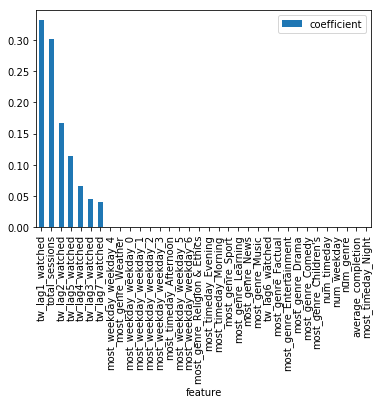

In [34]:
# Now let's plot them all
coefLR.sort_values(by='coefficient', ascending=False).plot(kind='bar')
plt.show()

So, as expected we see a drastically different distribution of coefficients to our previous two models, with only seven of the original thirty-four coefficients included different from zero.

Interestingly, the lasso model has also chosen very different features to the ones weighted highest by the previous two models. The previous two models achieve their highest accuracy from quite a complex combination of positive and negative coefficients that describe the most frequent genre of content and viewing time; while they weighted minutes watched in previous weeks relatively low.

Conversely, the lasso model improves on those  previous models by throwing out all the genre and viewing time features and including just seven positive coefficients that weight the minutes watched in previous weeks. 

<a id='model_perf_comp'></a>
# Model Performance Comparison

Now that we have trained tree different models with our dataset, let's visualise their results.

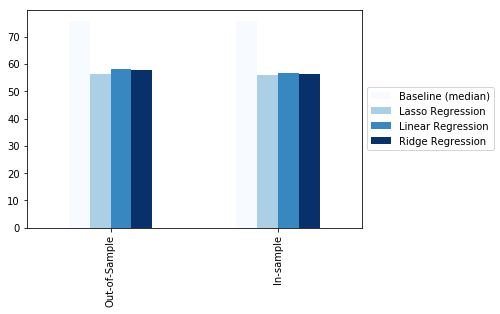

In [36]:
# We will negate the accuracy here as it's easier to read 
# and then plot the errors: the best model is the one than MINIMIZES these values
scores = pd.DataFrame({'Baseline (median)':[metrics.mean_absolute_error(target,median_forecast),
                                            metrics.mean_absolute_error(target,median_forecast)],
                       'Linear Regression':[-np.mean(MR_oos), -MR_is], 
                       'Ridge Regression':[-RR_best_score, -RR_is],
                       'Lasso Regression':[-LR_best_score, -LR_is]},
                      index=['Out-of-Sample','In-sample'])

scores.plot(kind='bar', colormap='Blues')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

We can see from this plot that the performance of our regression models are difficult to tell apart. The original multivariate regression model and the ridge regression are particularly difficult to distinguish while the lasso model exhibits marginally the best performance, in terms of MAE.

On the basis of these results, it is likely that each of the three models would not perform significantly better than each other on new data but if we follow _Occam's razor_, the lasso model makes the fewest assumptions, is the least complex and is therefore most likely to generalise to new data.

<a id='combine'></a>
# Combine the Regression and Classification Models
Now that we have a model to predict wether a user will consume on the last two-week group, and a model that forecast the minutes watched, we can combine the two in order to generate an overall score.

For the classifier we will use a Random Forest with the following hyperparameters: Max Depth 6, Min Sample Leaf 75. For the regression we will use the Lasso framework with a regularisation parameter equal to 0.1.

<a id='retrain_classif'></a>
## Retrain our Classifier
Let's first get our data back for the classification output and then retrain our classifier.

In [37]:
# We put both target arrays (regression and classification) in the same txt file
# As both target arrays have the same size we just need to split it it two
# and get the correct part for the prediction task
target_class = np.split(np.loadtxt('target.txt'), 2)[1].flatten()
target_class[:10]

array([ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.])

In [39]:
# Classifier with the hyperparameters tuned from last course
from sklearn.ensemble import RandomForestClassifier
forrestclass=RandomForestClassifier(n_estimators=200,
                                    max_depth=6,
                                    min_samples_leaf=75)
RF=forrestclass.fit(features,target_class)
print("In-sample accuracy RF: "+str(RF.score(features,target_class)))

In-sample accuracy: 0.800043922258


Our model has a good accuracy. Let's have a look at the other metrics that we usually use to assess the performance of a classifier: __precision__ and __recall__.

For more details see: https://en.wikipedia.org/wiki/Precision_and_recall

Confusion matrix, without normalization
[[4831  583]
 [1238 2455]]
Normalized confusion matrix
[[ 0.89  0.11]
 [ 0.34  0.66]]


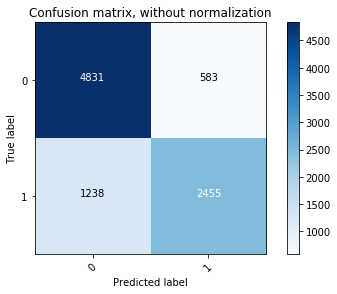

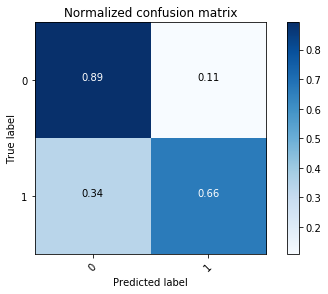

In [50]:
# Let's have a look at the confusion matrix of our classifier
from sklearn.metrics import confusion_matrix
class_names=[0,1]

# We found this code here:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix=confusion_matrix(target_class, RF.predict(features))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The __confusion matrix__ help us to understand the performance of our classifier. Overall, our accucary is quite good looking at the number of correct predictions (diagonal of the matrix).

Let's have a look at the other metrics.

In [61]:
# Recall: how many relevant items (class 1) are selected?
# Or in other words, what is the proportion of class 1 our model managed to get?
nb_class1=cnf_matrix[1][0]+cnf_matrix[1][1]
nb_class1_pred_true=cnf_matrix[1][1]
print('Among the '+str(nb_class1)+
      ' users who consumed content, the classifier identified '+str(nb_class1_pred_true)+
      '. \nRecall: '+str(nb_class1_pred_true/nb_class1))

Among the 3693 users who consumed content, the classifier identified 2455. 
Recall: 0.664771188735


In [63]:
# Precision: how many selected items (predicted as class 1) are relevant?
# Or in other words, what is the proportion of true class 1 in our class 1 predictions?
nb_class1_pred_false=cnf_matrix[0][1]
print('Among the '+str(nb_class1_pred_false+nb_class1_pred_true)+
      ' users our model forecasted to consume content, '+str(nb_class1_pred_true)+
      ' did. \nPrecision: '+
      str(nb_class1_pred_true/(nb_class1_pred_true+nb_class1_pred_false)))

Among the 3038 users our model forecasted to consume content, 2455 did. 
Precision: 0.808097432521


<a id='overall_score'></a>
## Compute the Overall Score and it's Performance
Let's now combine the outputs of our classifier and our regressor to forecast the minutes watched.

To do so we will simply multiply our two outputs:
- if the classifier forecast for a given user class 1, i.e. he or she consumes content, then the overall score output will be the one of the regressor;
- if the classifier forecast class 0, i.e. he or she doesn't consume content, then the overall score will be zero, and thus even if our regressor forecasts a number of minutes watched non equal to zero.


In [65]:
# Let's compute our overall score by multiplying the two outputs
# Note that we can easily do that are we already controlled for the order in our users
overall_score=RF.predict(features)*LR.predict(features)
overall_score[:10]

array([  0. ,  93.9,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ])

In [66]:
# Let's now have a look at the in-sample error
comb_is=-metrics.mean_absolute_error(target,overall_score)
print(comb_is)

-49.8074606238


The combination of the two models improves the overall performance of our regression task.

# Summary

In this tutorial we have explored how to train statistical models that can handle linear output variables: regressors.

- We looked at the different ways in which the performance of a regression model can be evaluated and the importance of establishing a baseline of error.
- We used our data to train three different types of regression models and evaluated their performance: multivariate linear regression; ridge regression and lasso regression.
- We learnt about the concept of _regularization_: an approach that aims to reduce the problem of very large coefficients in regression models, which can lead to overfitting.
- We learnt how to interpret a regression model by inspecting the coeffcients. Here we found clear differences between the three models, giving us a more unituitive understanding of how the workings of the models differed.

# Training Recap

Over the four tutorials in this course, we have covered a lot. You may not feel like an expert data science yet but if you feel comfortable with everything we have done so far, you are certainly on your way there. 

To recap, the first tutorial helped us understand how to formulate our data science problem and select the dataset we need to solve it. We decided that it would be useful to try and predict engagement statistics of users within a two-week period, based upon their viewing behaviour in the previous 14 weeks. To solve this problem we decided to use a dataset containing the views of 10,000 iPlayer viewers.

In the second tutorial we introduced the concept of data wrangling - transforming and preparing our dataset so that it is ready to be ingested into our statistical learning models. It is these models that alllow us to make engagement predictions and forecasts about our users.

In the third tutorial, we were introduced to our first classifier models: how to train them and how to evaluate their performance. We used four classifiers to forecast whether or not a user was "engaged" with iPlayer, in a sense that he or she will consume content on the last two-week group.

In this final tutorial, we introduced our first regression models. These allowed us to forecast the amount of engagement with iPlayer content. Finally, we combine the two type of modeling to get the most of our data and the patterns found in it. 

We hope you enjoyed joining us on this course and that you found it helpful in your development as a world-leading data scientist!

-Datalab Team